In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [5]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

In [6]:
df = pd.concat([train, test])

In [7]:
df = df.set_index('PassengerId')

In [8]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [9]:
age_mean = df["Age"].mean()
age_std = df["Age"].std()

rand_sample = np.random.uniform(age_mean - age_std, age_mean + age_std, size = df["Age"].isnull().sum())
df.loc[df['Age'].isna(), 'Age'] = rand_sample

In [10]:
tmp = np.array(df['Cabin'].apply(lambda x: ['-1', '-1', '-1'] if type(x)==float else x.split('/')).to_list())

df['Cabin_deck'] = tmp[:, 0]
df['Cabin_num'] = tmp[:, 1]
df['Cabin_side'] = tmp[:, 2]

In [11]:
df.drop(columns='Cabin', inplace=True)

In [12]:
df.loc[df['Cabin_deck']=='-1','Cabin_deck'] = np.random.choice(
    ['F','G','E','B','C','D','A'], sum(df['Cabin_deck']=='-1'), 
    p=[0.3349, 0.2986, 0.1045, 0.0901, 0.087, 0.0569, 0.028])

df['Cabin_deck'] = df['Cabin_deck'].map({'F': 0, 'G': 1, 'E': 2, 'B': 3, 'C': 4, 'D': 5, 'A': 6, 'T': 7})

In [13]:
df['Cabin_num'] = df['Cabin_num'].astype(int)

df.loc[df['Cabin_num']=='-1', 'Cabin_num'] = int(df['Cabin_num'].mean())

In [14]:
df.loc[df['Cabin_side']=='-1', 'Cabin_side'] = np.random.choice(['S', 'P'], sum(df['Cabin_side']=='-1'), 
                                                                p=[0.5036, 0.4964])

df['Cabin_side'] = df['Cabin_side'].map({'S': 0, 'P': 1})

In [15]:
df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(
    ['Earth', 'Europa', 'Mars'], 
    sum(df['HomePlanet'].isna()), 
    p=[0.5413, 0.247, 0.2117])

df['HomePlanet'] = df['HomePlanet'].map({'Earth': 0, 'Europa': 1, 'Mars': 2})

In [16]:
df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(
    ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], 
    sum(df['Destination'].isna()), 
    p=[0.7, 0.208, 0.092])

df['Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2})

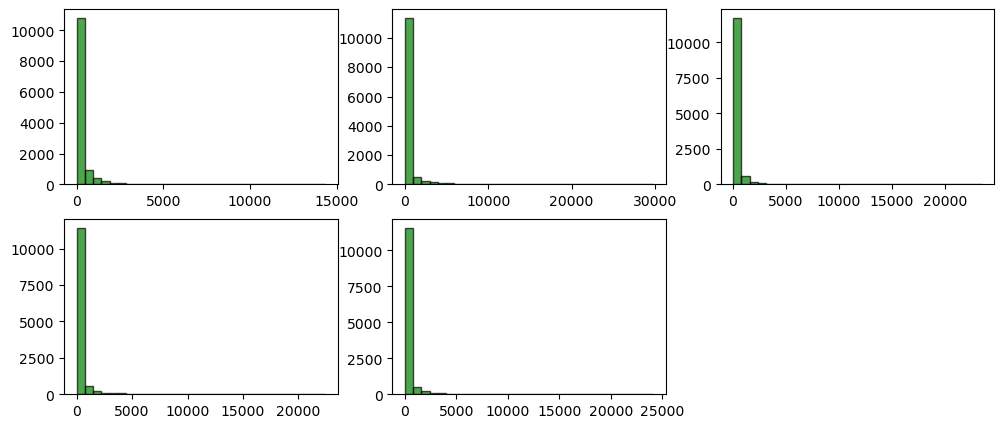

In [17]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize=(12, 5))
for i in range (0, len(cols)):
    fig.add_subplot(2, 3, i+1).hist(df[cols[i]], bins=30, alpha=0.7, color='green', ec='black')

In [18]:
for col in cols:
    df[col].fillna(df[col].median(), inplace=True)

In [19]:
df.loc[df['CryoSleep'].isna(), 'CryoSleep'] = np.random.choice([True, False],
                                                                sum(df['CryoSleep'].isna()),
                                                                p=[0.362, 0.638])
df['CryoSleep'] = df['CryoSleep'].astype(int)

df.loc[df['VIP'].isna(), 'VIP'] = np.random.choice([True, False],
                                                    sum(df['VIP'].isna()),
                                                    p=[0.022, 0.978])
df['VIP'] = df['VIP'].astype(int)

In [20]:
df['Name'].fillna('Unk Unk', inplace=True)

In [21]:
tmp = np.array(df['Name'].apply(lambda x: x if type(x)==float else x.split(' ')).to_list())

df['Name_first'] = tmp[:, 0]
df['Name_last'] = tmp[:, 1]

In [22]:
label_encoder = LabelEncoder()
df["Name_first"] = label_encoder.fit_transform(df.loc[:, "Name_first"])

label_encoder = LabelEncoder()
df["Name_last"] = label_encoder.fit_transform(df.loc[:, "Name_last"])

In [23]:
df.drop(['Name'], axis=1, inplace=True)

In [24]:
summary('df', df)

df shape: (12970, 16)


,dtypes,null,unique,min,median,max,mean,std
HomePlanet,int64,0,3,0,0.0,2,0.669314,0.803104
CryoSleep,int64,0,2,0,0.0,1,0.361758,0.480528
Destination,int64,0,3,0,0.0,2,0.394526,0.652061
Age,float64,0,350,0.0,27.0,79.0,28.767853,14.287799
VIP,int64,0,2,0,0.0,1,0.021280,0.144321
RoomService,float64,0,1578,0.0,0.0,14327.0,218.378026,641.766201
FoodCourt,float64,0,1953,0.0,0.0,29813.0,441.890979,1568.038076
ShoppingMall,float64,0,1367,0.0,0.0,23492.0,170.779491,584.153630
Spa,float64,0,1679,0.0,0.0,22408.0,301.722282,1118.746785
VRDeck,float64,0,1642,0.0,0.0,24133.0,300.450270,1168.655639


In [25]:
train = df.iloc[:8693,:]
test = df.iloc[8693:,:]

In [26]:
train['Transported'] = train['Transported'].astype('int64')

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['Transported'], axis=1), 
                                                      train[['Transported']],
                                                      test_size=0.3, random_state=42)

In [28]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
clf_xgb = XGBClassifier('binary:logistic', colsample_bytree=0.4603, gamma=0.0468, 
                                           learning_rate=0.05, max_depth=10, 
                                           min_child_weight=1.7817, n_estimators=1500,
                                           reg_alpha=4.5, reg_lambda=8.5,
                                           subsample=0.5213, random_state=42)
clf_lgb = LGBMClassifier()
clf_cat = CatBoostClassifier(verbose=False)

In [30]:
x, y = X_train, y_train

cv_xgb = cross_val_score(clf_xgb, x, y, cv=5, scoring='accuracy').mean()
cv_lgbm = cross_val_score(clf_lgb, x, y, cv=5, scoring='accuracy').mean()
cv_cat = cross_val_score(clf_cat, x, y, cv=5, scoring='accuracy').mean()

In [31]:
clf_xgb.fit(x, y,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=25,
            verbose=False)

clf_lgb.fit(x, y,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=25,
            verbose=False)

clf_cat.fit(x, y,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=25,
            verbose=False)

In [32]:
y_pred_xgb = clf_xgb.predict(X_valid)
y_pred_lgbm = clf_lgb.predict(X_valid)
y_pred_cat = clf_cat.predict(X_valid)

In [33]:
print("XGBoost CV Accuracy: ", cv_xgb)
print("LightGBM CV Accuracy: ", cv_lgbm)
print("CatBoost CV Accuracy: ", cv_cat)
print('-' * 45)
print('validation xgb score:', accuracy_score(y_pred_xgb, y_valid.values))
print('validation lgbm score:', accuracy_score(y_pred_lgbm, y_valid.values))
print('validation CatBoost score:', accuracy_score(y_pred_cat, y_valid.values))

XGBoost CV Accuracy:  0.8014790468364833
LightGBM CV Accuracy:  0.8026294165981923
CatBoost CV Accuracy:  0.8106820049301561
---------------------------------------------
validation xgb score: 0.7952453987730062
validation lgbm score: 0.8025306748466258
validation CatBoost score: 0.7971625766871165


In [34]:
X = train.drop('Transported', axis=1).copy()
y = train[['Transported']].copy()

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X = X.values
y = y.values

In [35]:
Seed = 7
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=Seed)
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 16),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1,
        'verbose': False
    }
    scores = []
    for train_idx, valid_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20, verbose=False)
        y_prob = model.predict(X_valid)
        score = accuracy_score(y_valid,y_prob)
        scores.append(score)
    
    mean_score = np.mean(scores)
    return mean_score

In [36]:
best_params = {'learning_rate': 0.018049356549743555,
 'depth': 6,
 'l2_leaf_reg': 7.838880563296214,
 'border_count': 182,
 'verbose' : False}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)

In [37]:
test.drop(['Transported'], axis=1, inplace=True)
y_pred = final_model.predict(test)

In [47]:
df_submit = pd.DataFrame({'PassengerId': test.index,
                          'Transported': y_pred})

df_submit['Transported'] = np.where(df_submit['Transported'] == True, 1, 0)

In [49]:
df_submit.head()

,PassengerId,Transported
0,0013_01,0
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
